# Riddler Classic - April 5, 2019

## Problem
_Lucky you! You’ve won two gift cards, each loaded with 50 free drinks from your favorite coffee shop, Riddler Caffei-Nation. The cards look identical, and because you’re not one for record-keeping, you randomly pick one of the cards to pay with each time you get a drink. One day, the clerk tells you that he can’t accept the card you presented to him because it doesn’t have any drink credits left on it._

_What is the probability that the other card still has free drinks on it? How many free drinks can you expect are still available?_

## Solution

### My Approach
#### Assumptions
To me, the problem seems to have a small ambiguity, namely whether we should include the possibility of the other card having been declined before this incident. I'm guessing the arbiter of Riddler Nation [Oliver Roeder](https://www.reddit.com/r/IAmA/comments/9ooyec/i_am_oliver_roeder_fivethirtyeight_staff_writer/) would have explicitly said if we were to include this possibility, so I will not factor it in. In other words, I'm assuming this is the first time in which either gift card has been declined.  

#### Analytic Approach
##### Probability of still having free drinks on the other card
Let $X_1$ be the total number of drinks obtained until 50 drinks were obtained with card 1. Similarily, let $X_2$ be the total number of drinks obtained until 50 drinks were obtained with card 2.  Both $X_1$ and $X_2$ are [negative binomial distributions](https://en.wikipedia.org/wiki/Negative_binomial_distribution) where $X_1 \sim X_2 \sim NegativeBinomial(k; 51, 0.5)={k+51-1 \choose k}(.5)^k(.5)^{50}$

We use $51$ because the card will only be declined when we attempt to use the 51st time.  

Let's assume $X_1$ is declined first. To determine the probabability that card 2 has exactly 0 drink remaining, we can evaluated $X_2$ exactly at $k=50$.  This yields $P(X_2=50)={50+51-1 \choose 50}(.5)^{50}(.5)^{50}$

In [45]:
import math

def choose(n, m):
    assert(n>=m)
    return math.factorial(n) / (math.factorial(m)*math.factorial(n-m))

def evaluate_neg_binomial(k, r, p):
    return choose((k+r-1), k) * p**k * (1-p)**r

r = 51
p = .5
k = 50
no_val_remaining = evaluate_neg_binomial(k, r, p)

In order to account for the possiblity that $X_2$ is the first to get declined, we can simply double the probability we just obtained (because $X_1$ and $X_2$ are symmetric) to get the total probability that there is no monely remaining on the non-declined card.  

In [46]:
print("{0}% chance that the other card still has free drinks".format((1-2*no_val_remaining)*100))

92.04107626128213% chance that the other card still has free drinks


So the answer to the first questions is __92.04%__

##### Number of free drinks remaining
Now to determine the average number of drinks remaining, we calculate $50-\mathbf{E}(X_2 \mid X_2 \le 50)$.  This expectation can easily by calculated with $\frac {\sum \limits_{k=0}^{50}k{k+51-1 \choose k}(.5)^k(.5)^{50}}{\sum \limits_{k=0}^{50}{k+51-1 \choose k}(.5)^k(.5)^{50}}$

In [47]:
total_pdf_area = 0
unweighted_expectation = 0
for k in range(1,r):
    pdf_area = choose((k+r-1), k) * p**k * (1-p)**r
    total_pdf_area += pdf_area
    unweighted_expectation += k*pdf_area
        
expectation = unweighted_expectation/total_pdf_area
print("Average of {0} free drinks remaining on the other card".format(50-expectation))

Average of 7.038512976105018 free drinks remaining on the other card


So the answer to the second question is __7.039__

#### Code
Because I have no confidence in my analytic prowess, I will use a monte carlo simulation to verify that my analytic solution is correct.  To start, let's import the packages we'll need.  

In [48]:
import random
from matplotlib import pyplot as plt
import operator
from multiprocessing import cpu_count, Pool

Now, let's define a class to will help us simulate our situation.  `Gift_Cards` will be able to run our simulation using any number of cards with any number of free drinks loaded on them (but the number of drinks have to be the same for all the cards).  

In [49]:
class Gift_Cards(object):

    def __init__(self, num_cards = 2, num_drinks_on_card = 50):
        self.num_cards = num_cards
        self.num_drinks_on_card = num_drinks_on_card

    def use_cards(self):
        """Run a simulation of randomly using the gift cards
        
        Arguments: (none)
        Return:
        left_on_cards: dictionary of number of drinks left on each card
        """
        random.seed()
        left_on_cards = {str(i+1):50 for i in range(self.num_cards)}
        any_declined = False
        while not any_declined:
            c = str(random.randint(1, self.num_cards))
            left_on_cards[c] -= 1
            if left_on_cards[c] == -1:
                any_declined = True
            else:
                continue
        return left_on_cards
    
    def run_2_cards_trials(self, num_trials):
        """Runs trials for the case with 2 cards

        Arguments:
        num_trails: number of trials to be run
        Return:
        avg_drinks_left: average num drinks remaining on other card
        """       
        assert(self.num_cards == 2)
        drinks_left = []
        for i in range(num_trials):
            drinks_left.append(max(self.use_cards().items(), key=operator.itemgetter(1))[1])
        return (sum(drinks_left)/num_trials, drinks_left)

    def parallel_2_cards_trials(self, num_trials):
        """Runs trials for the case with 2 cards in parallel

        Arguments:
        num_trails: number of trials to be run
        Return:
        avg_drinks_left: average num drinks remaining on other card
        """       
        assert(self.num_cards == 2)
        pool = Pool(cpu_count())

        results = [pool.apply_async(self.use_cards) for _ in range(num_trials)]
        drinks_left = [max(r.get().items(), key=operator.itemgetter(1))[1] for r in results]
        return (sum(drinks_left)/num_trials, drinks_left)

Now we can go ahead and run the simulation.  

In [50]:
if __name__ == "__main__":
    num_trials = 1000000
    g = Gift_Cards(2, 50)
    avg_drinks, dist_drink = g.parallel_2_cards_trials(num_trials)

The `parallel_2_cards_trials` method returns the average number of drinks remaining on the non-depleted card and a list of the number of remaining drinks on the non-depleted card for each trial. So we can print and graph the results directy from this information.  

92.0594% chance that the other card still has free drinks
Average of 7.039572 free drinks remaining on the other card


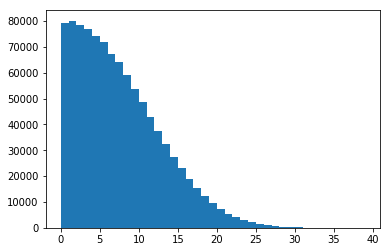

In [51]:
    print("{0}% chance that the other card still has free drinks".format((1 - dist_drink.count(0) / num_trials)*100))
    print("Average of {0} free drinks remaining on the other card".format(avg_drinks))
    plt.hist(dist_drink, bins=range(40))
    plt.show()

These values match pretty well with the analytically obtained solution!  Hopefully they turn out to be correct.  